In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

In [3]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [4]:
batch_size=128

In [5]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


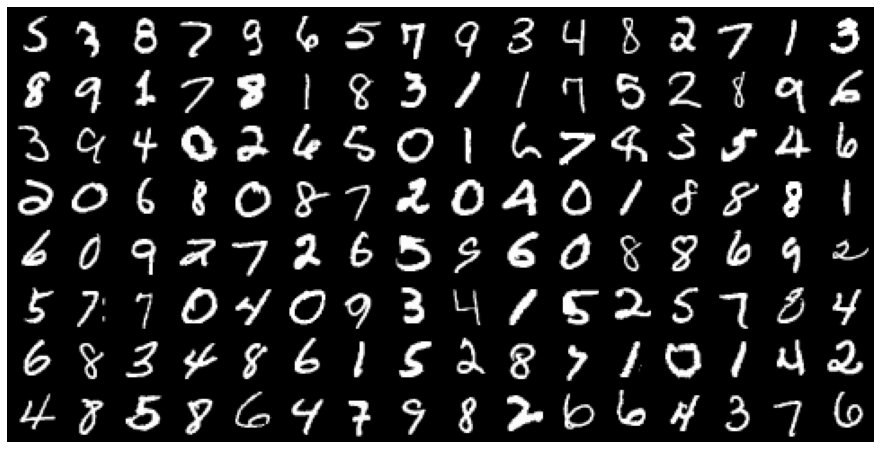

In [6]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [7]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break


images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [8]:
input_size = inputs.shape[-1]
hidden_size = 32

In [9]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
input_size=784
hidden_size=32
num_classes=10

In [12]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [13]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.337451934814453
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.1517, -0.2029,  0.0593, -0.1928,  0.1760,  0.1229, -0.2105, -0.0066,
         -0.0702, -0.0324],
        [ 0.2172, -0.1665,  0.1158, -0.1051,  0.1266,  0.0290, -0.1353, -0.0574,
         -0.0777, -0.2642]])


In [14]:
torch.cuda.is_available()

False

In [15]:
def get_default_device():
    """Pick GPU if Available else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [16]:
device=get_default_device()
device

device(type='cpu')

In [17]:
def to_device(data,device):
    """Move tensor(s) to chosen device"""
    if isinstance(data,(list,tuple)):
        return [(to_device(x,device)) for x in data]
    return data.to(device,non_blocking=True)

In [18]:
for image,labels in train_loader:
    print(image.shape)
    image=to_device(image,device)
    print(image.device)
    break

torch.Size([128, 1, 28, 28])
cpu


In [19]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
train_loader=DeviceDataLoader(train_loader,device)
val_loader=DeviceDataLoader(val_loader,device)

In [21]:
for xb,yb in val_loader:
    print("xb.device:",xb.device)
    print('yb:',yb)

xb.device: cpu
yb: tensor([3, 2, 9, 1, 9, 8, 4, 4, 7, 8, 7, 4, 1, 6, 3, 0, 1, 3, 0, 4, 0, 3, 0, 6,
        4, 1, 3, 4, 0, 2, 6, 3, 3, 2, 6, 7, 4, 6, 8, 2, 2, 6, 3, 2, 1, 2, 4, 4,
        3, 5, 7, 5, 7, 2, 5, 7, 6, 7, 3, 4, 3, 8, 9, 9, 8, 0, 0, 1, 7, 2, 3, 0,
        9, 1, 0, 8, 9, 2, 8, 0, 1, 8, 9, 6, 9, 6, 5, 2, 1, 4, 2, 8, 0, 2, 6, 5,
        3, 0, 7, 6, 1, 0, 3, 1, 2, 7, 8, 3, 5, 4, 3, 5, 4, 9, 7, 6, 0, 8, 8, 1,
        0, 6, 7, 9, 9, 1, 6, 8, 5, 1, 6, 1, 5, 3, 1, 2, 1, 6, 1, 9, 1, 1, 5, 7,
        9, 6, 0, 9, 6, 6, 1, 2, 9, 1, 1, 4, 2, 3, 8, 9, 9, 5, 7, 4, 6, 1, 0, 9,
        9, 2, 4, 8, 5, 8, 8, 9, 0, 8, 7, 4, 3, 4, 1, 9, 1, 0, 6, 1, 5, 4, 6, 8,
        8, 1, 4, 9, 6, 2, 6, 8, 9, 3, 9, 6, 0, 2, 3, 1, 8, 6, 5, 4, 2, 5, 1, 0,
        6, 8, 1, 6, 1, 7, 5, 0, 7, 5, 5, 6, 2, 2, 7, 2, 5, 7, 3, 2, 1, 7, 0, 3,
        5, 5, 9, 9, 0, 1, 1, 3, 2, 5, 7, 5, 4, 7, 7, 1])
xb.device: cpu
yb: tensor([7, 8, 9, 3, 2, 8, 8, 4, 1, 5, 1, 6, 7, 5, 9, 1, 1, 5, 3, 8, 7, 9, 3, 9,
        8, 2, 8, 5, 4, 7,

xb.device: cpu
yb: tensor([1, 4, 0, 7, 4, 5, 7, 1, 2, 1, 8, 3, 2, 0, 0, 0, 0, 0, 8, 1, 2, 5, 3, 8,
        8, 1, 9, 7, 1, 3, 7, 4, 9, 0, 4, 1, 2, 2, 7, 9, 0, 1, 2, 6, 8, 8, 4, 0,
        4, 3, 1, 1, 9, 2, 2, 7, 6, 6, 9, 4, 2, 1, 5, 3, 2, 2, 6, 0, 4, 7, 1, 2,
        0, 3, 2, 4, 3, 9, 4, 7, 4, 1, 7, 0, 7, 9, 6, 5, 3, 8, 0, 3, 9, 7, 0, 1,
        7, 1, 7, 5, 9, 1, 9, 5, 0, 6, 4, 6, 2, 1, 2, 4, 5, 5, 6, 2, 6, 8, 1, 4,
        7, 0, 4, 0, 4, 6, 9, 7, 2, 3, 3, 3, 0, 7, 0, 6, 6, 6, 7, 1, 8, 1, 3, 3,
        2, 4, 1, 0, 9, 1, 6, 4, 4, 9, 2, 9, 9, 4, 5, 4, 8, 5, 8, 3, 3, 7, 6, 9,
        5, 3, 0, 9, 0, 7, 0, 7, 3, 9, 5, 4, 2, 5, 1, 5, 9, 4, 5, 2, 0, 8, 3, 8,
        1, 0, 3, 9, 5, 3, 0, 1, 3, 4, 2, 7, 3, 1, 0, 2, 4, 5, 2, 8, 8, 7, 9, 7,
        2, 9, 9, 0, 2, 2, 7, 3, 5, 3, 2, 0, 0, 6, 2, 9, 5, 7, 0, 4, 2, 3, 4, 9,
        3, 3, 0, 4, 3, 0, 9, 1, 4, 6, 7, 7, 7, 0, 9, 6])
xb.device: cpu
yb: tensor([0, 2, 9, 0, 1, 2, 5, 3, 0, 8, 9, 3, 1, 3, 2, 2, 1, 9, 5, 1, 3, 4, 6, 8,
        1, 1, 9, 4, 9, 0,

xb.device: cpu
yb: tensor([6, 4, 9, 9, 9, 4, 4, 7, 3, 2, 3, 4, 3, 2, 4, 9, 9, 9, 0, 4, 9, 7, 1, 3,
        4, 2, 3, 6, 7, 3, 2, 3, 8, 4, 9, 9, 9, 1, 7, 7, 8, 8, 0, 9, 0, 3, 7, 6,
        0, 5, 0, 3, 0, 7, 9, 4, 3, 5, 1, 8, 7, 6, 5, 4, 4, 6, 6, 1, 7, 1, 5, 9,
        4, 5, 0, 9, 7, 6, 1, 4, 6, 1, 4, 6, 4, 1, 6, 0, 0, 5, 9, 5, 3, 8, 5, 1,
        4, 3, 3, 3, 7, 2, 0, 4, 4, 1, 7, 3, 8, 6, 7, 2, 2, 6, 8, 6, 9, 2, 1, 3,
        7, 1, 5, 0, 4, 6, 2, 9, 9, 4, 2, 0, 6, 1, 2, 0, 0, 8, 5, 8, 2, 4, 9, 0,
        0, 6, 7, 3, 6, 1, 1, 2, 4, 5, 1, 0, 6, 5, 8, 1, 4, 8, 6, 3, 5, 4, 9, 2,
        4, 1, 6, 1, 9, 2, 6, 2, 2, 6, 7, 0, 5, 9, 2, 8, 2, 1, 2, 2, 6, 4, 3, 5,
        8, 8, 1, 1, 5, 6, 7, 6, 7, 3, 6, 2, 6, 1, 8, 9, 7, 7, 3, 6, 0, 5, 8, 0,
        9, 4, 3, 4, 1, 0, 8, 7, 9, 7, 5, 9, 0, 2, 8, 1, 6, 8, 2, 5, 9, 5, 6, 3,
        7, 7, 3, 9, 7, 8, 4, 6, 0, 5, 0, 3, 1, 5, 0, 2])
xb.device: cpu
yb: tensor([0, 4, 7, 1, 4, 7, 2, 9, 7, 1, 9, 9, 5, 0, 1, 3, 0, 5, 5, 2, 5, 9, 1, 6,
        5, 3, 6, 0, 6, 0,

In [22]:
def evaluate(model,val_loader):
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
    history=[]
    optimizer=opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss=model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result=evaluate(model,val_loader)
        model.epoch_end(epoch,result)
        history.append(result)
    return history
    

In [23]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [24]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3127081394195557, 'val_acc': 0.10859374701976776}]

In [25]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2731, val_acc: 0.9159
Epoch [1], val_loss: 0.1655, val_acc: 0.9482
Epoch [2], val_loss: 0.1709, val_acc: 0.9481
Epoch [3], val_loss: 0.1568, val_acc: 0.9521
Epoch [4], val_loss: 0.1554, val_acc: 0.9543


In [26]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1238, val_acc: 0.9628
Epoch [1], val_loss: 0.1200, val_acc: 0.9634
Epoch [2], val_loss: 0.1206, val_acc: 0.9628
Epoch [3], val_loss: 0.1192, val_acc: 0.9616
Epoch [4], val_loss: 0.1186, val_acc: 0.9635


In [27]:
history += fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1184, val_acc: 0.9648
Epoch [1], val_loss: 0.1184, val_acc: 0.9646
Epoch [2], val_loss: 0.1185, val_acc: 0.9647
Epoch [3], val_loss: 0.1183, val_acc: 0.9644
Epoch [4], val_loss: 0.1183, val_acc: 0.9642


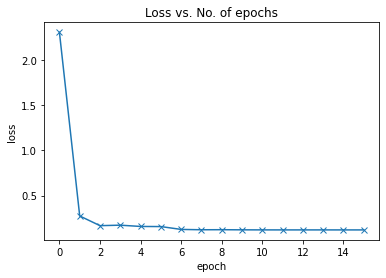

In [28]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [29]:
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [30]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10289232432842255, 'val_acc': 0.969042956829071}